In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import warnings
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

In [ ]:
# Import data
HMD = [file for file in sorted(glob.glob('Data/HMD Data/*.csv')) if file not in ('Data/HMD Data/EGW.csv','Data/HMD Data/SCO.csv')]

HMD_files = enumerate(HMD, 0)
HMD_data = {idx: pd.read_csv(file) for idx, file in HMD_files}

UN_files = enumerate(sorted(glob.glob('Data/UN Data/*.csv')), 0)
UN_data = {idx: pd.read_csv(file) for idx, file in UN_files}

# Remove discontinuity for Belgium
HMD_data[0] = HMD_data[0].loc[(HMD_data[0]['Year'] < 1915) | (HMD_data[0]['Year'] > 1919)].reset_index(drop = True)

In [ ]:
# Compare HMD and UN data to confirm accuracy
countries = ['Belgium', 'Switzerland', 'Denmark', 'Finland', 'France', 'Iceland', 'Italy', 'Netherlands', 'Norway', 'Sweden']

for i in range(len(HMD_data)):

    data = pd.merge(HMD_data[i], UN_data[i], 'outer', left_on = 'Year', right_on = 'Time', copy = False).rename(
    columns = {'Population_x':'HMD Population',
                'Mortality_x':'HMD Mortality',
                'Population_y':'UN Population',
                'Mortality_y':'UN Mortality'}).iloc[:-1]
    data.drop(columns = 'Time', inplace = True)

    data['HMD Population'] = data['HMD Population'] / 1000
    
    # Plot all other countries
    t = data['Year']
    N_HMD = data['HMD Population']
    N_UN = data['UN Population']

    fig, ax = plt.subplots()
    ax.plot(t, N_HMD, color = 'blue', label = 'HMD Population')
    ax.plot(t, N_UN, color = 'red', label = 'UN Population')
    
    plt.ylabel('Population (N)')
    plt.xlabel('Time (t)')
    plt.legend()

    plt.title(countries[i])

    plt.show())

In [ ]:
# Estimate dN/dt using central finite difference method; plot against time and population
for i in range(len(HMD_data)):

    t = HMD_data[i]['Year'] 
    N = HMD_data[i]['Population']

    dNdt = []

    # Compute non-boundary dN/dt
    for j in range(1, len(N) - 1):
        dN = (N[j + 1] - N[j - 1]) / (t[j + 1] - t[j - 1])
        dNdt.append(dN)

    # Restrict to 1885 - 2019
    HMD_data[i] = HMD_data[i].loc[1:len(dNdt)]

    HMD_data[i]['dN/dt'] = dNdt

    t = HMD_data[i]['Year']
    N = HMD_data[i]['Population']
    dNdt = HMD_data[i]['dN/dt']

    # Plot dN/dt over time for each country
    fig, ax1 = plt.subplots()
    ax1.plot(t, N, color = 'blue', label = 'N') 
    ax1.set_ylabel('Population (N)')

    ax2 = ax1.twinx()
    ax2.plot(t, dNdt, color = 'red', label = 'dN/dt')
    ax2.set_ylabel('Change in Population (dN/dt)')

    plt.xlabel('Time (t)')
    plt.title(countries[i])
    
    ax1.legend(loc = 'upper left')
    ax2.legend(loc = 'upper right')

    plt.show()

In [36]:
# Define cost function to determine fit of delayed logistic model
def cost(data, r, K, T):
    '''
    Computes the cost via squared difference between finite difference population change dN/dt and prediced change by delayed logistic model.

    Params:
    - data: Population data with columns 'Year', 'Population', 'dN/dt'
    - r: Intrinsic growth rate, undecomposed
    - K: Carrying capacity
    - T: Time lag for the population to reach reproductive maturity

    Output: 
    - cost: The sum of squared differences between the finite difference population change and predicted change by the delayed logistic model.
    '''

    # Lag population N(t - T) and drop empty entries for N(t - T)
    T = int(T)
    data['Lag Population'] = data['Population'].shift(T)
    data = data.dropna(subset = ['Lag Population'])

    # Calculated delayed logistic predicted change
    data['Logistic Change'] = r * data['Lag Population'] * (1 - data['Lag Population'] / K)

    # Compute cost
    data['Cost'] = (data['dN/dt'] - data['Logistic Change']) ** 2

    # Sum across time
    cost = data['Cost'].sum()

    return cost

# Define cost as objectiv function for minimzation
def cost_function(params, data):
    '''
    Creates an objective function for minimization using scipy.optimize.minimize
    '''

    # Define parameters
    r, K, T = params

    # T must be an integer for slicing
    T = int(T)

    return cost(data, r, K, T)

In [37]:
### RUN TIME 6m 21s. DO NOT RUN ###

# Minimize cost for each country
results = []

for i in range(len(HMD_data)):

    # Define parameters in grid search
    r_range = np.linspace(0, 1, 10)
    T_range = np.linspace(0, 200, 10)

    # for i in range(len(HMD_data)):

    # Initialize search
    best_params = None
    min_cost = np.inf

    # Define country-specific carrying capacity parameter grid
    N_max = np.floor(HMD_data[i]['Population'].max()).astype(int)
    K_range = np.linspace(N_max, 2 * N_max, 10)

    for r in r_range:
        for K in K_range: 
            for T in T_range:

                # Provide initial guess for the optimizer [r, K, T] 
                guess = [r, K, T]

                # Minimize cost
                result = minimize(cost_function, guess, args = (HMD_data[i]), method = 'L-BFGS-B')
                cost_val = result.fun

                # Compare search to ensure we are not finding a local minimum
                if cost_val < min_cost:
                    min_cost = cost_val
                    best_params = result.x

    # Extract optimal parameters
    r_star, K_star, T_star = best_params
    T_star = int(T_star)

    country_results = (r_star, K_star, T_star, min_cost)

    results.append(country_results)

In [38]:
# Format into dataframe
results_data = pd.DataFrame(results, columns = ['r', 'K', 'T', 'C'])
results_data['Country'] = countries

results_data = results_data[['Country', 'r', 'K', 'T', 'C']]

# Save data
results_data.to_csv('Data/delayed_logistic_fit_results.csv', index = False)

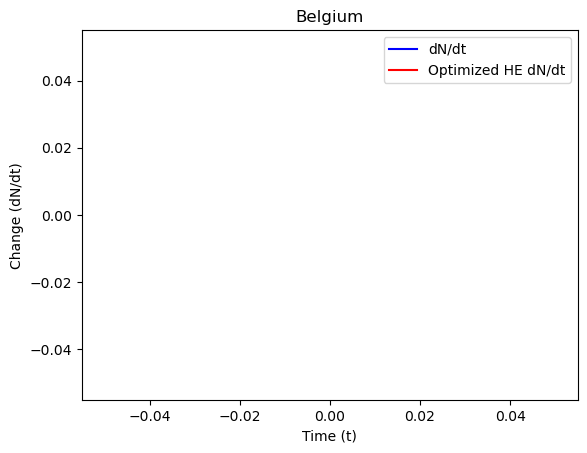

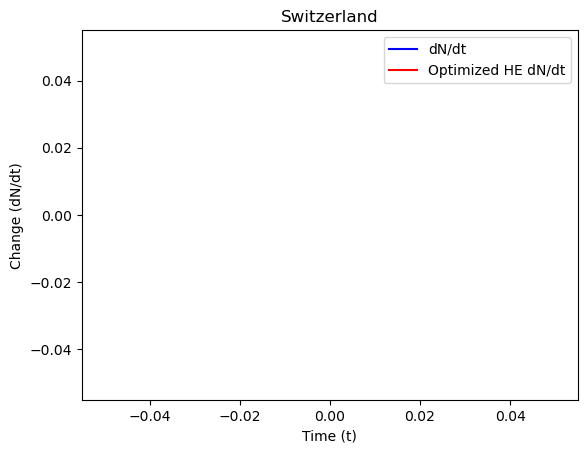

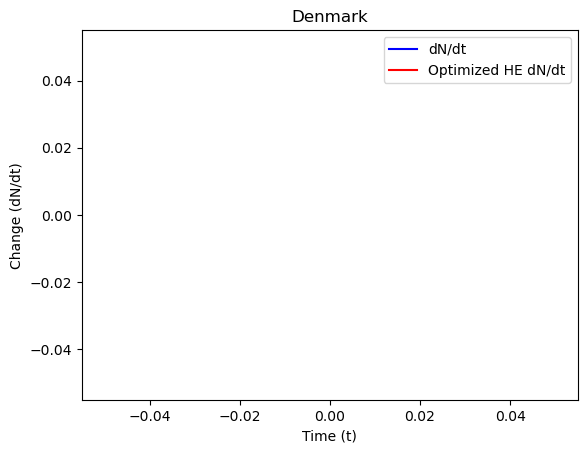

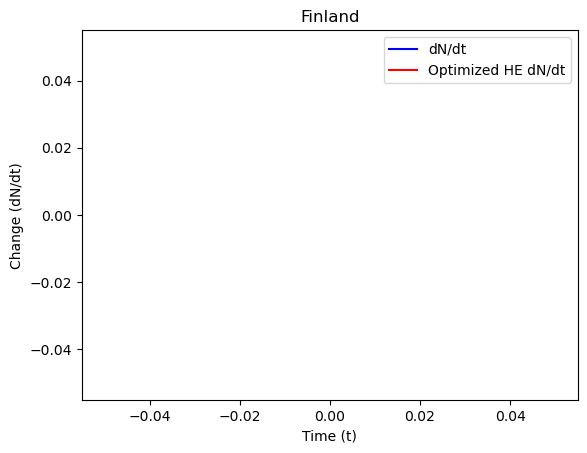

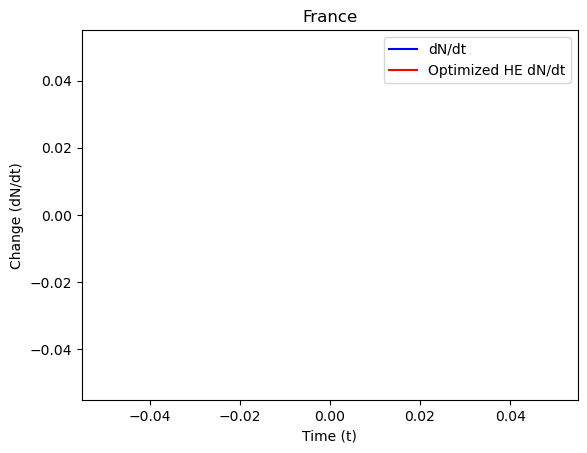

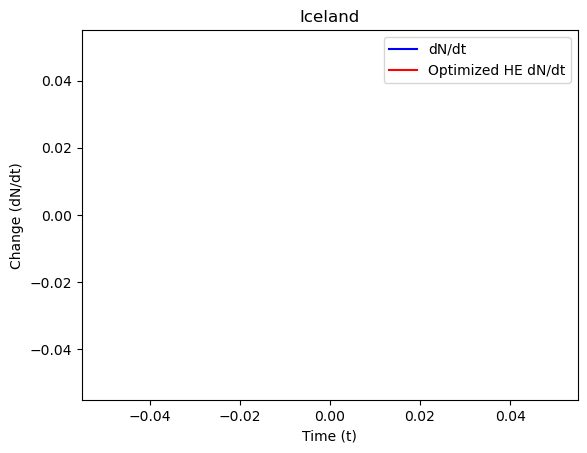

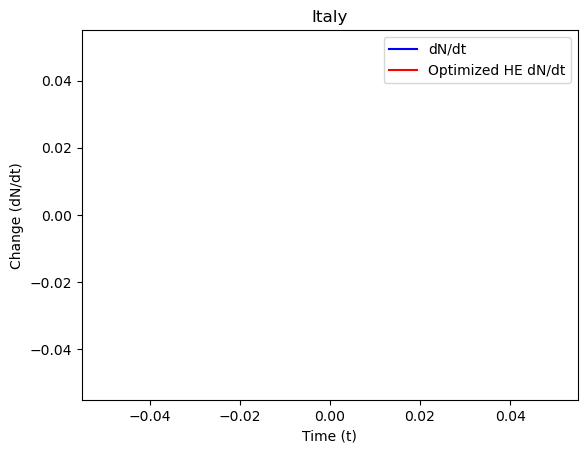

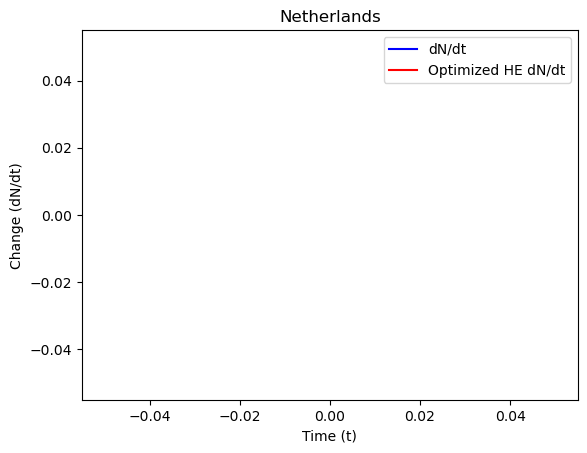

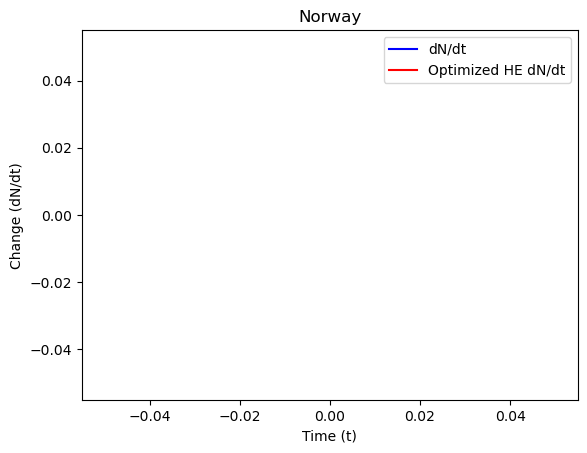

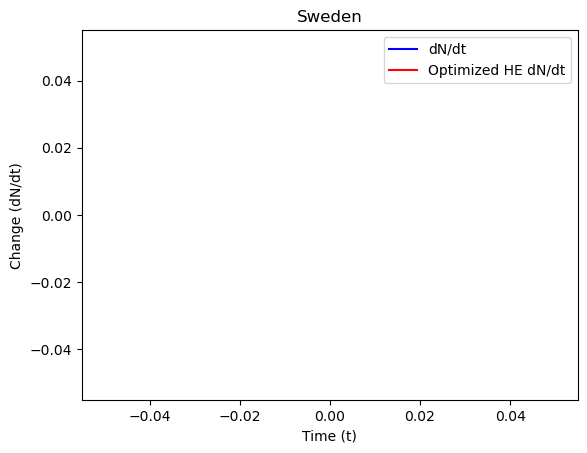

In [40]:
# Plot observed dN/dt against predicted dN/dt via delayed logistic model

# Import data to avoid re-running cost minimization
# results_data = pd.read_csv('Data/delayed_logistic_fit_results.csv')

# Define delayed logistic function
def delayed_logistic(data, r, K, T):
    '''
    Calculates dN/dt based on provided input value of N and parameters.

    Params:
    - data: Population data with columns 'Year', 'Population'
    - r: Intrinsic growth rate, undecomposed
    - K: Carrying capacity
    - T: Time lag for the population to reach reproductive maturity

    Output: 
    - dNdt: Calculation of dN/dt based on delayed logistic model. 
    '''

    # Lag population N(t - T) and drop empty entries for N(t - T)
    T = int(T)
    data['Lag Population'] = data['Population'].shift(T)
    data = data.dropna(subset = ['Lag Population'])

    # Calculated delayed logistic predicted change
    data['Logistic Change'] = r * data['Lag Population'] * (1 - data['Lag Population'] / K)

    return data

# Plot all countries dN/dt and optimized delayed logistic dN/dt against time to compare
for i in range(len(HMD_data)):

    data = delayed_logistic(HMD_data[i], results_data['r'][i], results_data['K'][i], results_data['T'][i])

    fix, ax = plt.subplots()
    ax.plot(data['Year'], data['dN/dt'], label = 'dN/dt', color = 'blue')
    ax.plot(data['Year'], data['Logistic Change'], label = 'Optimized HE dN/dt', color = 'red')

    plt.xlabel('Time (t)')
    plt.ylabel('Change (dN/dt)')
    plt.title(countries[i])

    plt.legend()

    plt.show()
